# Lab1

In [1]:
from IPython.core.display import display, HTML
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

## Library Importation

In [2]:
import pandas as pd
from kernel import *
from model import GaussianProcess
from visualization import visualize_ax
from utils import transform_time_hour, transform_time_day
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
data = pd.read_csv('data/sotonmet.txt', sep=",")

In [4]:
data.iloc[500:600]

,Update Date and Time (ISO),Update Duration (ms),Reading Date and Time (ISO),Air pressure (mb),Air temperature (C),Tide height (m),Wind direction (deg),Wind gust speed (kn),Wind speed (kn),True air temperature (C),True tide height (m),Independent tide height prediction (m),Independent tide height deviation (m),Dependent tide height prediction (m),Dependent tide height deviation (m),Independent air temperature prediction (C),Independent air temperature deviation (C),Dependent air temperature prediction (C),Dependent air temperature deviation (C)
500,2007-05-28T07:50:00,0,2007-05-28T07:50:00,1002.0,5.8,2.9,358.0,34.2,27.0,5.83,2.91,2.8857,0.017914,2.8859,0.018054,5.9356,0.14149,5.9522,0.14052
501,2007-05-28T07:55:00,0,2007-05-28T07:55:00,1002.0,5.8,3.0,359.0,32.1,24.8,5.83,2.98,2.9634,0.017353,2.9638,0.017472,5.9212,0.13762,5.9334,0.13672
502,2007-05-28T08:00:00,0,2007-05-28T08:00:00,1003.0,5.5,3.1,1.0,27.4,21.7,5.50,3.05,3.0498,0.017047,3.0505,0.017125,5.8232,0.13504,5.8317,0.13418
503,2007-05-28T08:10:00,0,2007-05-28T08:10:00,1003.0,5.9,3.2,352.0,35.2,24.9,5.42,3.17,3.1888,0.018906,3.1901,0.018988,5.8432,0.14721,5.8422,0.14613
504,2007-05-28T08:15:00,0,2007-05-28T08:15:00,1003.0,6.3,3.2,354.0,27.6,27.5,6.25,3.22,3.2349,0.017937,3.2360,0.018052,5.9748,0.14155,5.9676,0.14061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2007-05-28T20:15:00,0,2007-05-28T20:15:00,1009.0,10.6,3.4,341.0,10.3,10.0,11.25,3.36,3.3370,0.023967,3.3397,0.022663,11.4331,0.17492,11.4302,0.17300
596,2007-05-28T20:20:00,0,2007-05-28T20:20:00,1009.0,10.6,3.4,335.0,21.0,14.1,10.58,3.44,3.4263,0.022124,3.4238,0.021146,11.1076,0.16567,11.1081,0.16407
597,2007-05-28T20:25:00,0,2007-05-28T20:25:00,1009.0,11.2,3.5,338.0,24.7,18.4,11.17,3.50,3.4868,0.017237,3.4852,0.016880,10.9633,0.13596,10.9633,0.13508
598,2007-05-28T20:30:00,0,2007-05-28T20:30:00,1009.0,10.6,3.6,346.0,22.5,17.2,10.63,3.57,3.5480,0.020451,3.5442,0.019728,10.8873,0.15544,10.8835,0.15409


In [5]:
np.unique(data["Update Date and Time (ISO)"].values, return_counts = True)[0][(np.unique(data["Update Date and Time (ISO)"].values, return_counts = True)[1] > 1)]

array(['2007-05-28T16:10:00'], dtype=object)

In [8]:
# Get Data
y = data["Tide height (m)"]
y_norm = (y - np.mean(y)).values

# Ground Truth
y_true = data["True tide height (m)"]
y_true_norm = (y_true - np.mean(y_true)).values


# Reading Time
t = transform_time_day(data["Reading Date and Time (ISO)"])

# training / missing data

t_train = t[~data["Tide height (m)"].isnull()]
t_test = np.linspace(-1, 6, 1600)
t_test_true = t[data["Tide height (m)"].isnull()]

y_train = y_norm[~data["Tide height (m)"].isnull()]
y_test_true = y_true_norm[data["Tide height (m)"].isnull()]

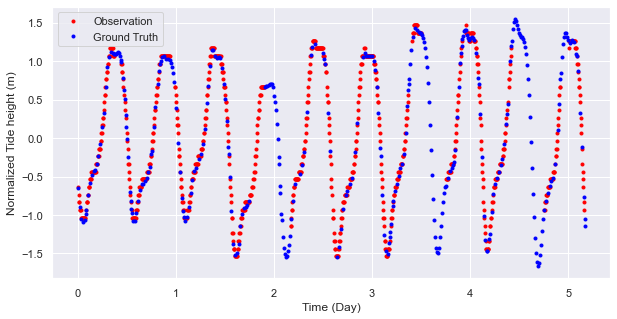

In [9]:
## Plot the data
plt.figure(figsize=(10,5))
plt.plot(t, y_norm, ".", color = "red", label = "Observation")
plt.plot(t_test_true, y_test_true, ".", color = "blue", label = "Ground Truth")
plt.xlabel("Time (Day)")
plt.ylabel("Normalized Tide height (m)")
plt.legend()
plt.savefig("Data.png", dpi = 150)

## Prior Functional Assumption
- Plot Functional Prior for different Kernels

C:\Users\Pierre Osselin\Desktop\Oxford\Course\data_inference\kernel.py:199: RuntimeWarning: invalid value encountered in multiply
  result = part1 * part2 * part3
C:\Users\Pierre Osselin\Desktop\Oxford\Course\data_inference\kernel.py:199: RuntimeWarning: invalid value encountered in multiply
  result = part1 * part2 * part3


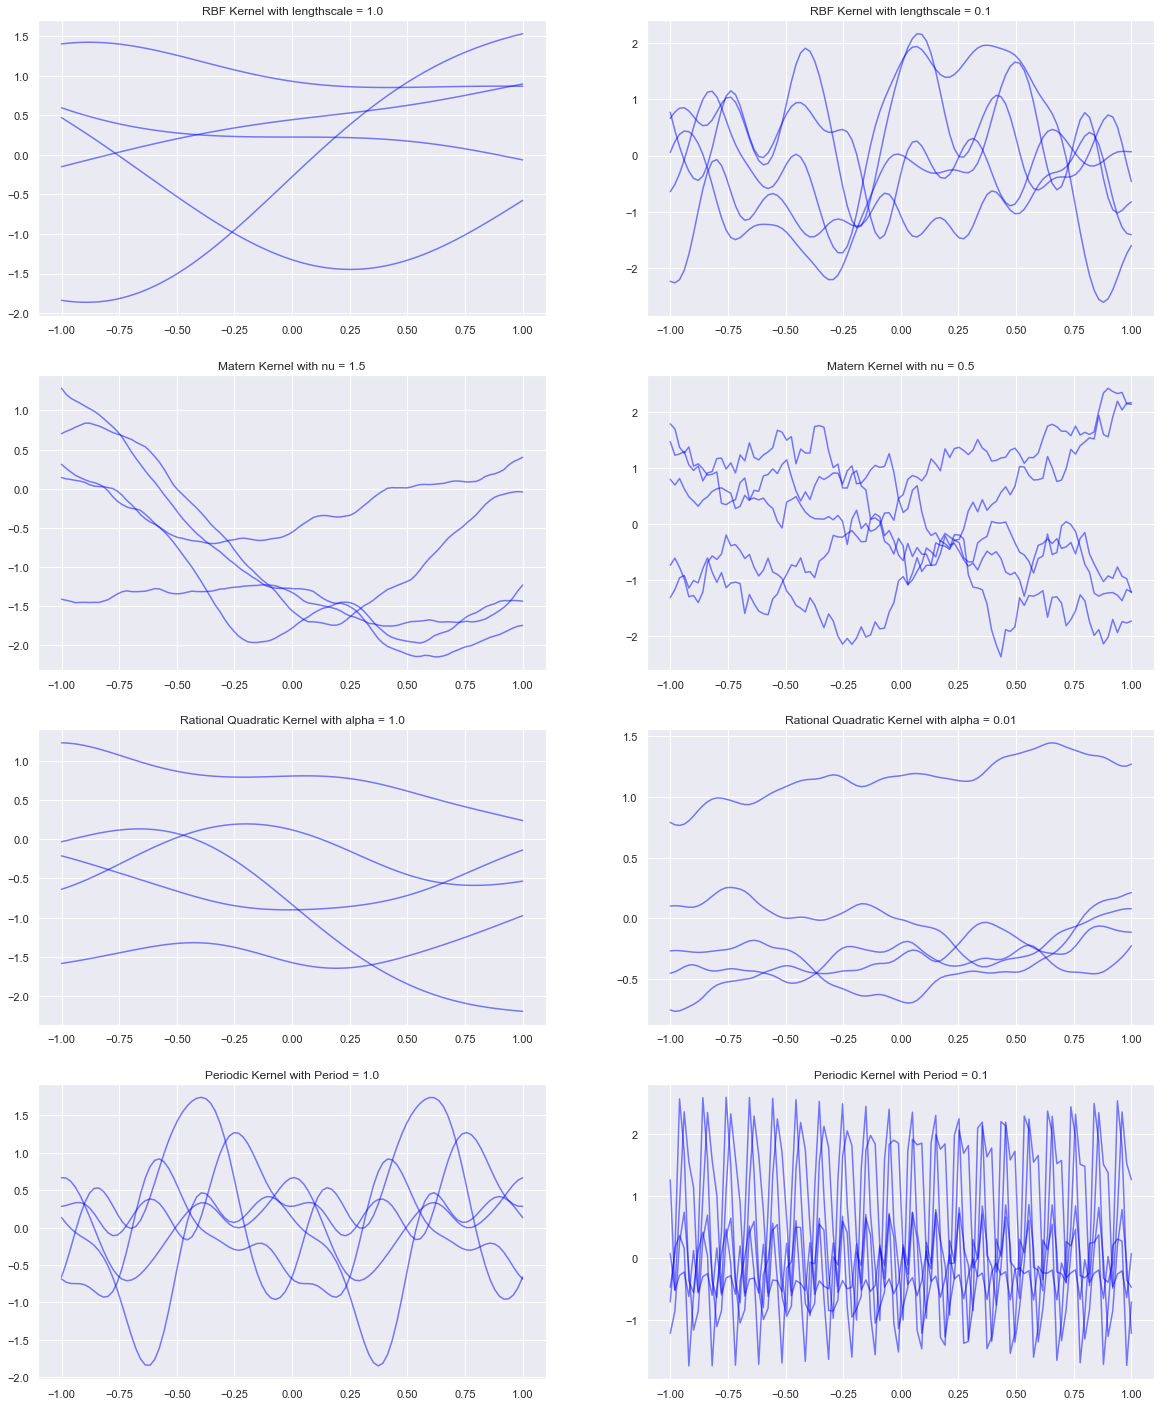

In [7]:
f, axs = plt.subplots(4,2, figsize=(20,25))

x = np.linspace(-1, 1, 100)
list_kernel = [RBF(1.), RBF(0.1), Matern(mu = 3/2), Matern(), RQ(alpha = 1.), RQ(alpha = 0.01), Periodic(p = 1.), Periodic(p = 0.1)]
for i, kernel in enumerate(list_kernel):
    K = kernel.compute_covariance(x.reshape(-1,1))
    samples = np.random.multivariate_normal([0 for i in range(len(x))], K, 5)
    for j in range(5):
        axs[i//2, i%2].plot(x, samples[j], "-", color='blue', alpha=0.5)
        
axs[0,0].set_title("RBF Kernel with lengthscale = {}".format(1.))
axs[0,1].set_title("RBF Kernel with lengthscale = {}".format(0.1))
axs[1,0].set_title("Matern Kernel with nu = {}".format(1.5))
axs[1,1].set_title("Matern Kernel with nu = {}".format(0.5))
axs[2,0].set_title("Rational Quadratic Kernel with alpha = {}".format(1.))
axs[2,1].set_title("Rational Quadratic Kernel with alpha = {}".format(0.01))
axs[3,0].set_title("Periodic Kernel with Period = {}".format(1.))
axs[3,1].set_title("Periodic Kernel with Period = {}".format(0.1))

plt.savefig("PriorSamples.png", dpi = 150)

## Gaussian Process Regression to Predict Missing Data

### Estimate Noise
- With Ground Truth
- With RBF Hyperparameter tuning
- Influence of Noise on Prediction

In [10]:
y_noise = data["Tide height (m)"][~data["Tide height (m)"].isnull()]
y_nnoise = data["True tide height (m)"][~data["Tide height (m)"].isnull()]
noise = np.sqrt(np.mean((y_noise - y_nnoise)**2))
print("Noise estimated : {}".format(noise))

Noise estimated : 0.029336538604165945


-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1574.3687501888342
Value Parameters: [0.06130411 0.80883021 0.02931456]
The noise hyperparameter is 0.02931455630950178


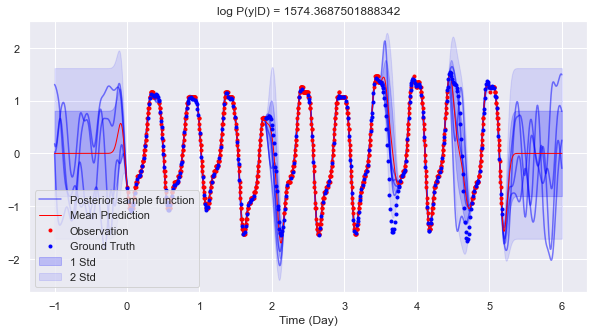

In [11]:
f, ax = plt.subplots(1,1, figsize=(10,5))
kernel = RBF(0.1)
model = GaussianProcess(kernel, noise = 0.5)
model.fit(t_train, y_train)
parameters, score = model.optimize(optimize_noise = True, verbose = 1)
result = model.predict(t_test)
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)
ax.set_title("log P(y|D) = {}".format(score))
print("The noise hyperparameter is {}".format(parameters[-1]))
plt.show()

Computing noise: 0.01
Computing noise: 0.03
Computing noise: 0.1
Computing noise: 1.0


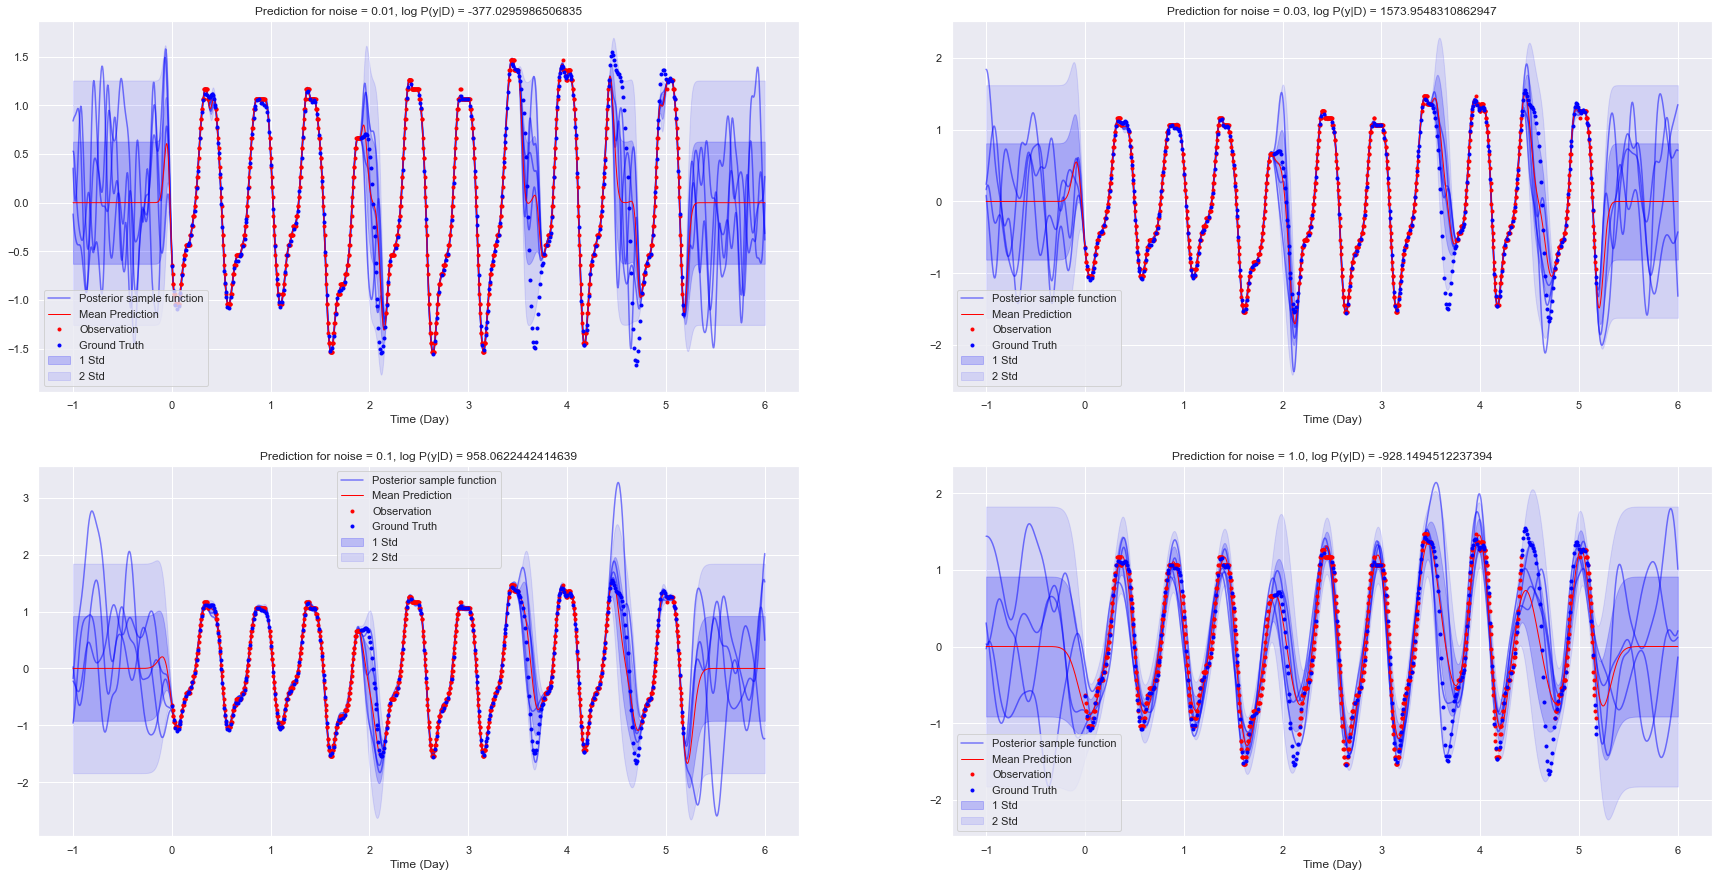

In [12]:
## Try noise levels : [0.01, 0.03, 0.1, 0.5] ~ 3 minutes
noise_list = [0.01, 0.03, 0.1, 1.]
f, axs = plt.subplots(2,2, figsize=(30,15))
kernel = RBF(0.1)

for i, noise in enumerate(noise_list):
    print("Computing noise:", noise)
    model = GaussianProcess(kernel, noise = noise)
    model.fit(t_train, y_train)
    _, score = model.optimize()
    result = model.predict(t_test)
    axs[i // 2, i % 2] = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title("Prediction for noise = {}, log P(y|D) = {}".format(noise, score))

**Comment:** With more noise the prediction is more diluted and regressed to the mean, as we can see on the last spikes of the last figure.

### Regression with Classical Kernels
- Gaussian Process Regression with Optimized Kernels
- Optimized kernels for RQ, Matern, Periodic and RBF
We implemented an hyperparameter optimizer that take any kernel structure and optimize its hyperparameter in the log space. Bounds can be included as well as parameter freezing.

Computing Kernel: RBF
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1511.390979478517
Value Parameters: [0.06283357 0.82109182]
Computing Kernel: RQ
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1515.7919955376533
Value Parameters: [0.07728329 4.00634141 0.94047517]
Computing Kernel: Matern
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1516.2125597093655
Value Parameters: [0.08263994 7.1893504  0.9437639 ]
Computing Kernel: Periodic
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: -6437.827138004904
Value Parameters: [0.13047719 0.5148059  0.71284427]


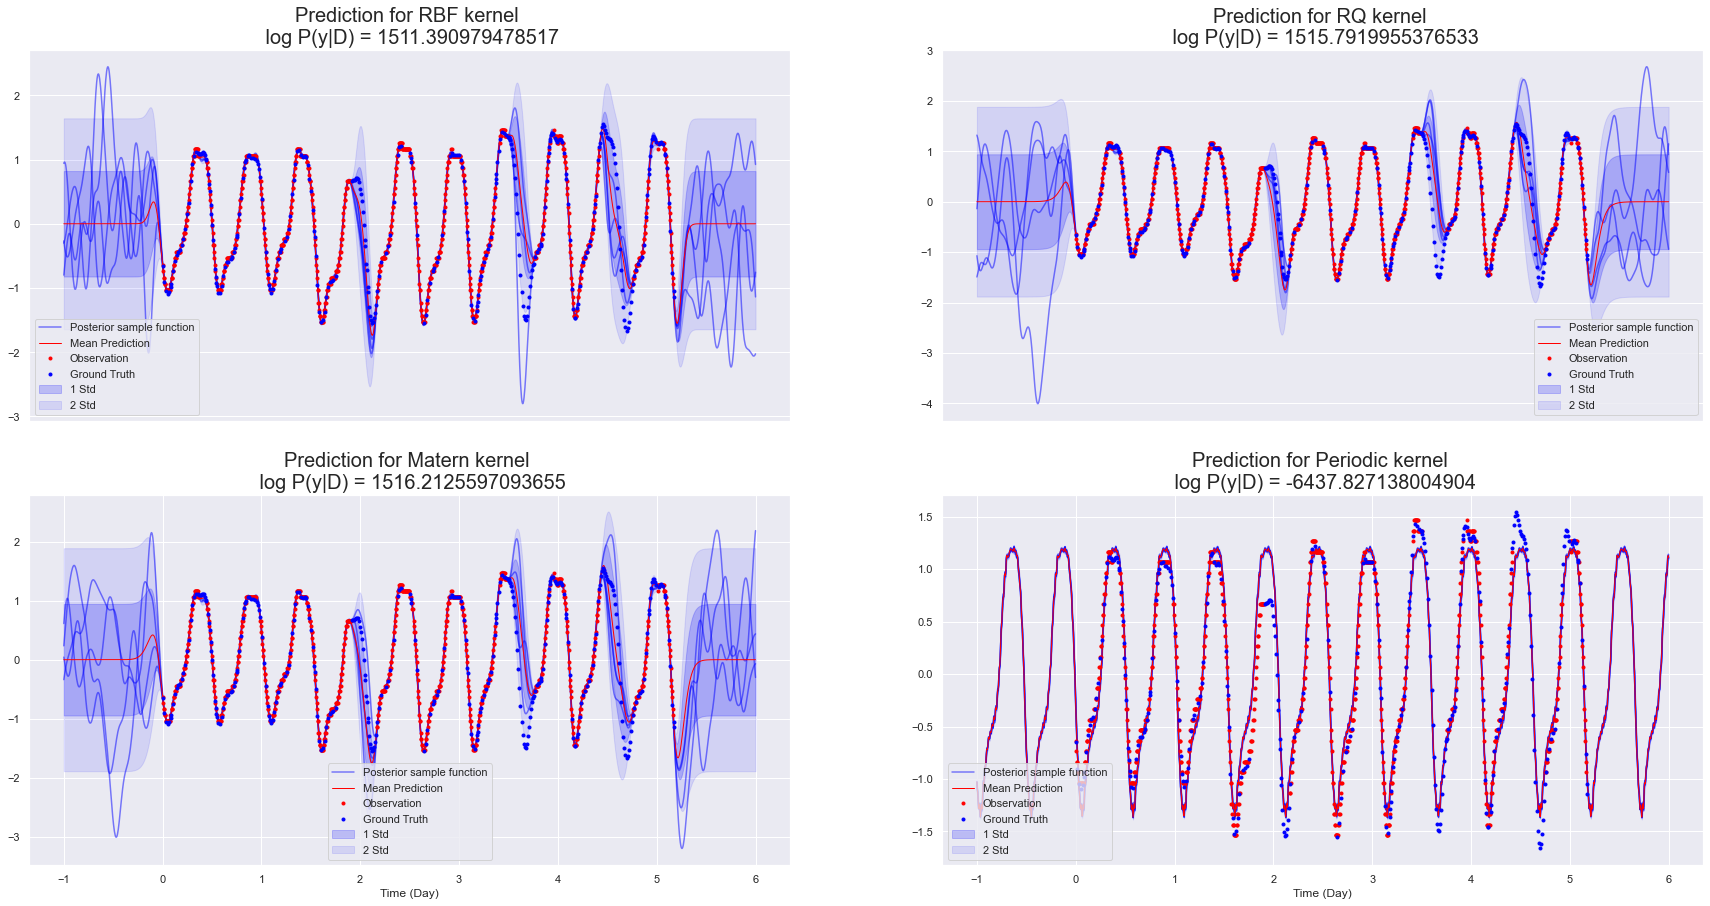

In [17]:
kernels = [(RBF(), "RBF"), (RQ(), "RQ"), (Matern(), "Matern"), (Periodic(), "Periodic")]
f, axs = plt.subplots(2,2, figsize=(30,15))
for i, (kernel, name) in enumerate(kernels):
    print("Computing Kernel:", name)
    model = GaussianProcess(kernel, noise = 0.04)
    model.fit(t_train, y_train)
    _, score = model.optimize(verbose = 1)
    result = model.predict(t_test)
    axs[i // 2, i % 2] = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title("Prediction for {} kernel \n log P(y|D) = {}".format(name, score), fontsize=20)

axs[0, 0].get_xaxis().set_visible(False)
axs[0, 1].get_xaxis().set_visible(False)

plt.savefig("ClassicalKernel.png", dpi = 150)

**Comments**: We can notice none of these kernels are able to capture the full data pattern:
- The Periodic Kernel fails to predict accurately the variability in the spikes intensity nor the roughness of the spikes. Moreover, the uncertainty is very small, this the typical behaviour of a kernel not expressive enough: given that the data is periodic, the whole complexity of the model has been filled and is certain of its predictions.

- We observe the same behavior for the RBf, RQ and Matern kernel, where the whole function smoothness of the function is captured in these model hyperparameters and the local roughness at some specific points is considered as noise, similarily the periodicity is clearly not captured when needed (for the Matern Kernel $\mu = 7.2$ which is high, and for RQ, $\alpha = 4.$ if these parameters are high the function modeled is smooth, the lengthscale found are similar).

### Combined Kernels
- Kernel Refinment with kernel combination

There is a global periodicity that should be captured via the addition of a Periodic Kernel. For the local roughness at the top of the spikes, we can model via a RQ, RBF or Matern kernel.

#### Periodic + {RBF, RQ, Matern} Kernel

In [ ]:
kernels = [(RBF(), "RBF"), (RQ(), "RQ"), (Matern(), "Matern")]
f, axs = plt.subplots(3,1, figsize=(30,20))
list_score = []
for i, (kernel, name) in enumerate(kernels):
    print("Computing Kernel:", name)
    model = GaussianProcess(Add_Kernel(kernel, Periodic()), noise = 0.04)
    model.fit(t_train, y_train)
    _, score = model.optimize(verbose = 1)
    list_score.append(score)
    result = model.predict(t_test)
    axs[i] = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, axs[i])
    axs[i].set_title("Prediction for Periodic + {} kernel \n log P(y|D) = {}".format(name, score), fontsize=20)
axs[0].set_title("Prediction for Periodic + {RBF, RQ, Matern} kernel \n log P(y|D) = {}".format(name, list_score[0]), fontsize=20)
axs[0].get_xaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
plt.savefig("AddKernel.png", dpi = 150)

Computing Kernel: RBF


#### Periodic x RBF + Periodic + RBF Kernel
- Blablabla

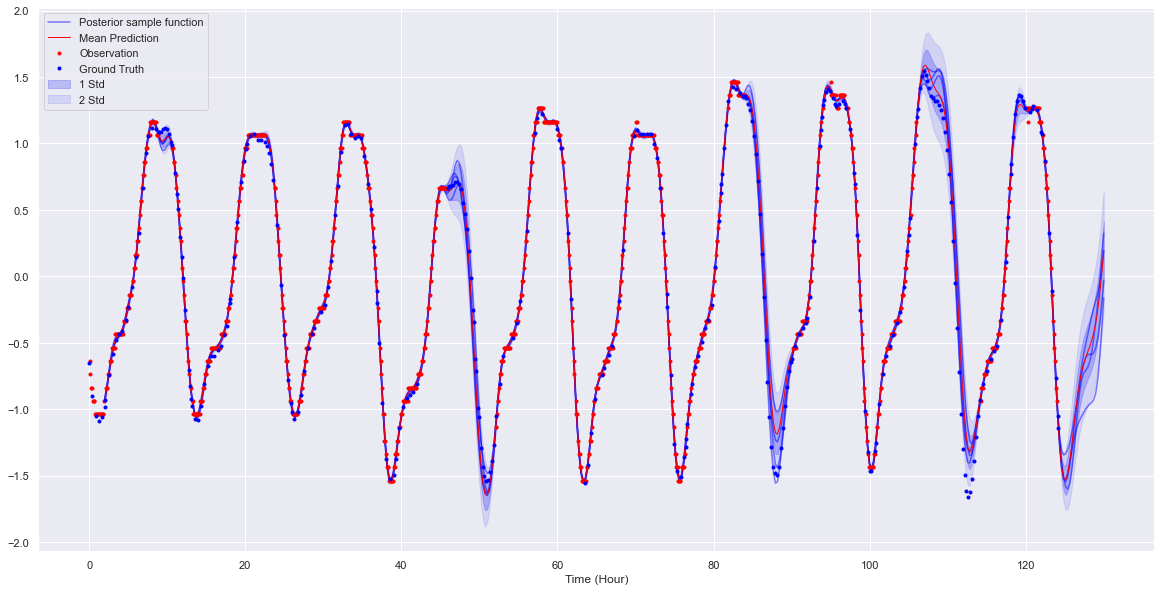

In [44]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

### Sequential

In [28]:
kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)


lookahead = 1.
t_test = np.linspace(0.,130., 500)
mean_prediction_sequential, var_prediction_sequential = model.sequential_prediction(t_test, split = 10., optimization = True, verbose = 1)

 11%|█████████▎                                                                          | 1/9 [00:00<00:06,  1.31it/s]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 174.28439508680776
Value Parameters: [1.84660404e+00 6.50317940e-01 1.18258451e+00 4.55644128e+01
 6.53765730e-01 6.43196088e-01 5.42496029e-02 5.37434746e-02
 2.11360365e+02 6.87739980e-01]


 22%|██████████████████▋                                                                 | 2/9 [00:03<00:10,  1.49s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 386.04437004060827
Value Parameters: [1.29870565e+01 2.11911693e-02 9.94456297e-01 2.21343960e+01
 2.12497233e-02 4.74943060e-01 1.83075205e-02 4.57737605e-01
 2.52615180e+01 7.62627038e-01]


 33%|████████████████████████████                                                        | 3/9 [00:13<00:23,  3.95s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 616.4611459413582
Value Parameters: [ 5.87291907  0.4435317   1.28850154 33.03451614  0.44299305  0.64790447
  0.04336986  0.48740961 25.06474282  0.83485588]


 44%|█████████████████████████████████████▎                                              | 4/9 [00:34<00:45,  9.14s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 740.3066108057714
Value Parameters: [ 0.82270021  0.25656611  1.03769503 25.45598667  0.25654247 14.6708296
  0.18036141  0.46212918 24.96530296  0.79085806]


 56%|██████████████████████████████████████████████▋                                     | 5/9 [01:28<01:29, 22.47s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 972.5031135532892
Value Parameters: [ 0.96066062  0.29831892  1.02637154 25.0985794   0.29850072  7.06824702
  0.14459955  0.40974621 24.86295632  0.74132737]


 67%|████████████████████████████████████████████████████████                            | 6/9 [02:31<01:44, 34.76s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1200.1248172049836
Value Parameters: [ 1.15885141  0.3403789   0.98980279 23.78964929  0.33992784  9.81973564
  0.13594077  0.39242435 24.81281891  0.73900767]


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:16<01:51, 55.59s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1312.2044129790806
Value Parameters: [ 1.04398483  0.33161364  1.02817275 24.98714083  0.33172354  9.1003455
  0.14254614  0.41707703 24.81251538  0.78197358]
-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1492.2519234054735
Value Parameters: [ 1.02844777  0.34858334  0.94853632 22.25704722  0.34852371  9.41231476
  0.15449091  0.43647604 24.76819679  0.8362517 ]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [05:39<01:04, 64.03s/it]

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1579.9267089339914
Value Parameters: [ 0.93345011  0.3044346   0.88956399 21.03769491  0.3046335   3.58154457
  0.18561768  0.44788812 24.76147377  0.87010502]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:19<00:00, 48.88s/it]


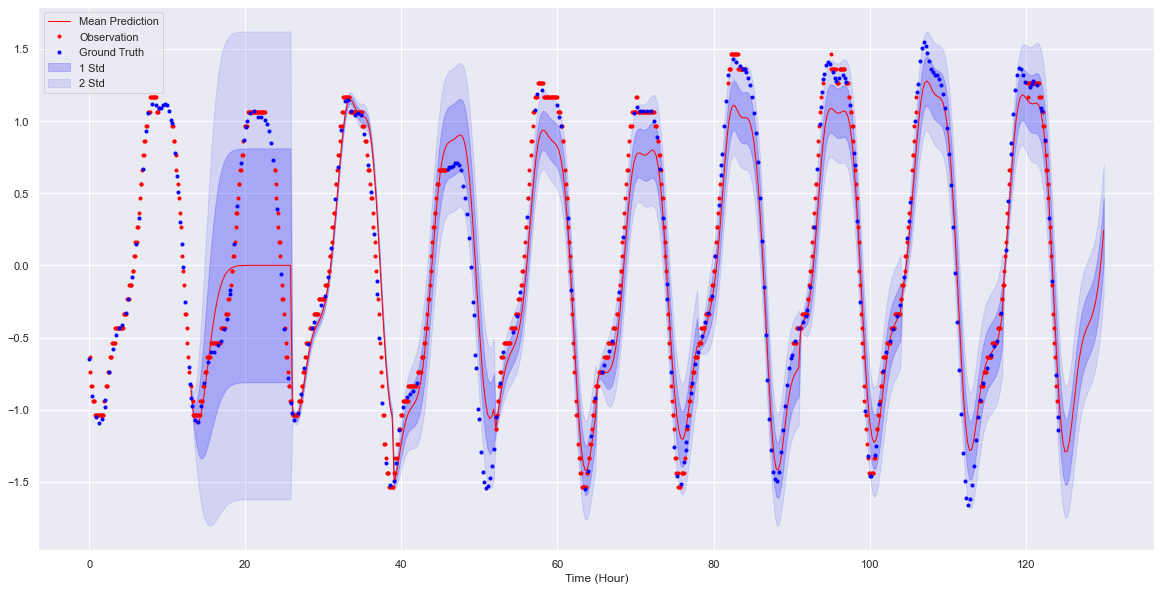

In [29]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  (np.array(np.split(t_test, 10)[1:])).flatten(), [mean_prediction_sequential, var_prediction_sequential], ax, size = 0)

In [39]:
np.array(np.split(t_test, 10)[1])

t_test_debug = np.split(t_test, 5)[1]
t_train_debug = t_train[t_train <= t_test_debug[0]]
y_train_debug = y_train[t_train <= t_test_debug[0]]

In [40]:
len(t_test)

500

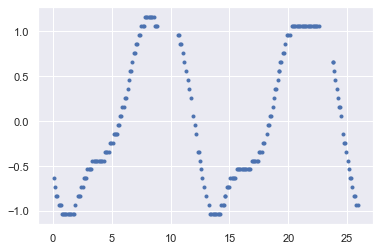

In [41]:
plt.plot(t_train_debug,y_train_debug, '.' )

In [42]:
kernel = Add_Kernel(Multiply_Kernel(RBF(), Periodic(1., 25.)), Add_Kernel(RBF(), Periodic(1., 25.)))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train_debug, y_train_debug)
model.optimize()

array([1.29870565e+01, 2.11911693e-02, 9.94456297e-01, 2.21343960e+01,
       2.12497233e-02, 4.74943060e-01, 1.83075205e-02, 4.57737605e-01,
       2.52615180e+01, 7.62627038e-01])

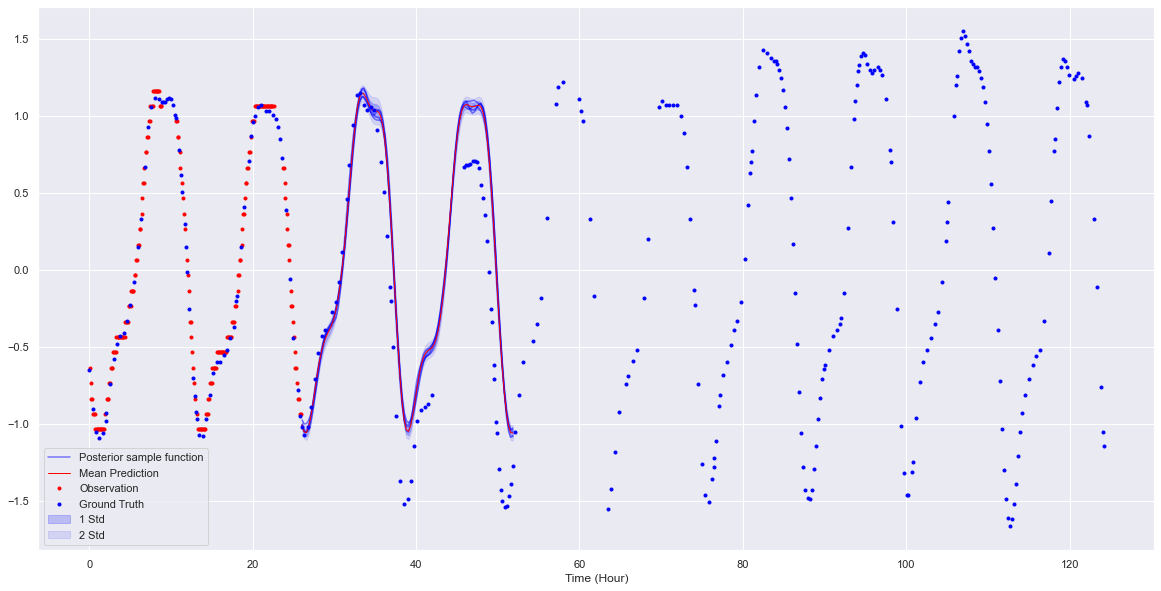

In [43]:
result = model.predict(t_test_debug)

f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train_debug, y_train_debug, t_test_true, y_test_true,  t_test_debug, result, ax)

ValueError: x and y must have same first dimension, but have shapes (50,) and (500,)

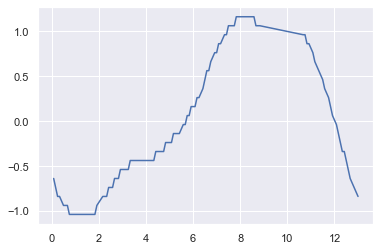

In [22]:
plt.plot(t_train_debug, y_train_debug)
plt.plot(t_test_debug, result[0])

In [23]:
t_test_debug

array([13.0260521 , 13.28657315, 13.54709419, 13.80761523, 14.06813627,
       14.32865731, 14.58917836, 14.8496994 , 15.11022044, 15.37074148,
       15.63126253, 15.89178357, 16.15230461, 16.41282565, 16.67334669,
       16.93386774, 17.19438878, 17.45490982, 17.71543086, 17.9759519 ,
       18.23647295, 18.49699399, 18.75751503, 19.01803607, 19.27855711,
       19.53907816, 19.7995992 , 20.06012024, 20.32064128, 20.58116232,
       20.84168337, 21.10220441, 21.36272545, 21.62324649, 21.88376754,
       22.14428858, 22.40480962, 22.66533066, 22.9258517 , 23.18637275,
       23.44689379, 23.70741483, 23.96793587, 24.22845691, 24.48897796,
       24.749499  , 25.01002004, 25.27054108, 25.53106212, 25.79158317])

In [24]:
result[0]

array([-6.23096944e-001, -7.94307047e-001, -9.23099078e-001,
       -1.00391741e+000, -1.04407614e+000, -1.05378543e+000,
       -1.03564431e+000, -9.85596061e-001, -9.03527487e-001,
       -8.00056017e-001, -6.92260276e-001, -5.95412840e-001,
       -5.19740131e-001, -4.70622365e-001, -4.45990403e-001,
       -4.33104449e-001, -4.13080651e-001, -3.72891899e-001,
       -3.12905030e-001, -2.41776281e-001, -1.65236205e-001,
       -8.05106253e-002,  2.09125668e-002,  1.47341232e-001,
        3.01140648e-001,  4.74368564e-001,  6.49769882e-001,
        8.09385615e-001,  9.43503506e-001,  1.04991208e+000,
        1.12535759e+000,  1.16210547e+000,  1.15607388e+000,
        1.11719204e+000,  1.06857584e+000,  1.03374943e+000,
        1.02383478e+000,  1.03453017e+000,  1.05121650e+000,
        1.05506319e+000,  1.02749183e+000,  9.55006229e-001,
        8.34055649e-001,  6.71454019e-001,  4.78331639e-001,
        2.62893217e-001,  2.94180768e-002, -2.15878579e-001,
       -4.59289832e-001,

In [ ]:
### Multioutput GP

## To Do :
- Debug Sequential Prediction
- Test Other Kernel implemented (Matern, Rational Quadratic)
- Explain why optimization not good when random initialiation : Try optimizer + Marginal Likelihood
- Implement Multioutput Gaussian

In [55]:
## Apply Gaussian Process Prediction

kernel = Add_Kernel(RBF(), Periodic(1., 40.))
model = GaussianProcess(kernel, noise = 0.03)
model.fit(t_train, y_train)
model.optimize(verbose = 1.)

result = model.predict(t_test)

-----Result Optimization-----
Convergence: True
Value Log Marginal Likelihood: 1633.5616101421824
Value Parameters: [ 1.10010854  0.18507542  0.29932994 37.07068936  0.88396504]


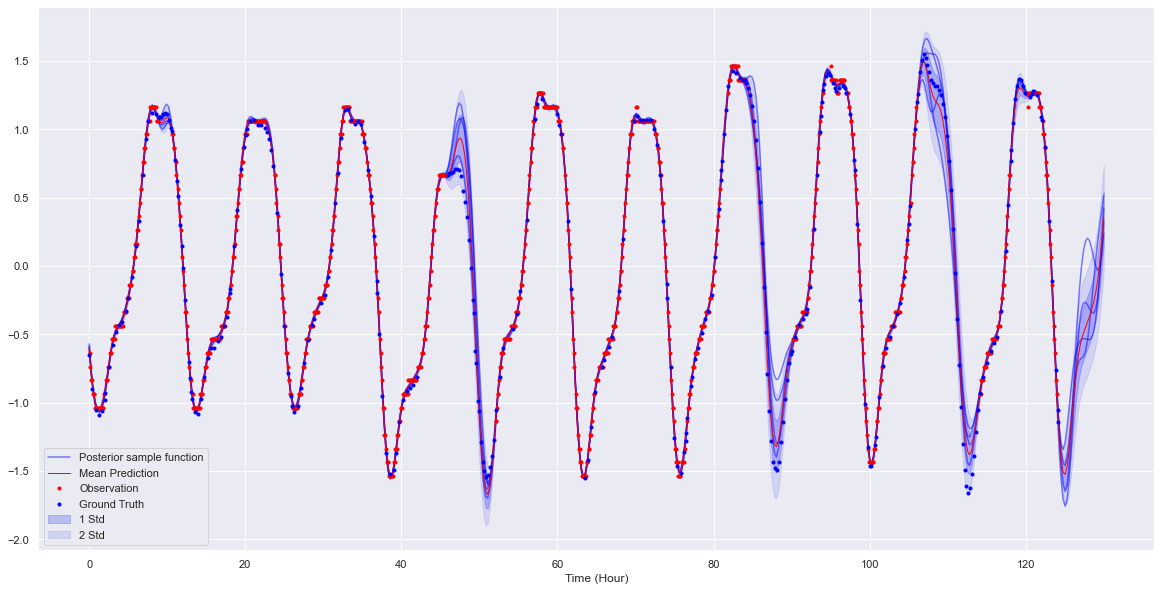

In [54]:
f, ax = plt.subplots(figsize=(20,10))
ax = visualize_ax(t_train, y_train, t_test_true, y_test_true,  t_test, result, ax)

1e+69